In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import time
from tqdm import tqdm,trange, tqdm_notebook
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import pickle
import scipy.stats
import scipy.io
from scipy.special import comb as nCk

In [2]:
def gain(mu,w):
    vec = w*np.sqrt(mu*(1-mu))
    return len(mu)*np.linalg.norm(vec,2)**2/np.linalg.norm(vec,1)**2

In [3]:
baseDir = "pkls/bern_n100_pareto/"


myData = pickle.load( open( "{}/info.pkl".format(baseDir), "rb" ) )
numTrials = myData['numTrials']
budgets = myData['budgets']
w = myData['w']
mu = myData['mu']
n = len(w)
print(n,numTrials,gain(mu,w))

100 100 66.35818724166843


In [4]:
## loading optimism based data

errArrOptimism = np.zeros((numTrials,len(budgets)))
pullArrOptimism = np.zeros((numTrials,len(budgets),n))
timingArr = np.zeros((numTrials,len(budgets)))

for i in range(numTrials):
    myData = pickle.load( open( "{}/adaOptBer_sim{}.pkl".format(baseDir,i), "rb" ) )
    errArrOptimism[i] = myData["errorArr"]
    pullArrOptimism[i] = myData["numPullsArr"]
    timingArr[i] = myData['time']

In [6]:
## loading batched sims

myData = pickle.load( open( "{}/batched.pkl".format(baseDir), "rb" ) )
unifErrorBatch, unifBudgetBatch, unifTimingArr = myData['unif']
adaErrorBatch, adaBudgetBatch, adaTimingArr = myData['ada']

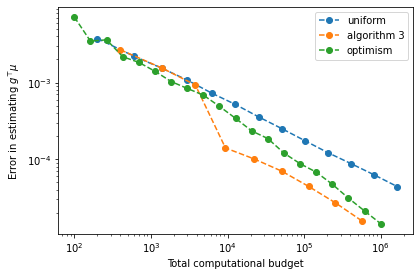

In [7]:
## Plotting error as a function of budget, as in Figure 3

plt.plot(unifBudgetBatch.mean(axis=0)[:-2],unifErrorBatch.mean(axis=0)[:-2],'--o',label='uniform')
plt.plot(adaBudgetBatch.mean(axis=0)[:-5],adaErrorBatch.mean(axis=0)[:-5],'--o',label='algorithm 3')

mask = ~np.isin(budgets,[10**x for x in [3,4,5]])
plt.plot(budgets[mask],errArrOptimism.mean(axis=0)[mask],'--o',label='optimism')


plt.yscale('log')
plt.xscale('log')
plt.xlabel("Total computational budget")
plt.ylabel(r'Error in estimating $g^\top \mu$')
plt.legend()
plt.rc('font', size=12)
plt.rc('axes',titlesize=12,labelsize=12)
plt.tight_layout()
# plt.savefig('figures/bernoulli_n10_pareto.pdf',bbox_inches='tight')

In [ ]:
## plotting time as a function of budget, showing near logarithmic scaling of batched methods
##   vs linear scaling of fully sequential optimism one
##   For table 1

plt.plot(unifBudgetBatch.mean(axis=0)[:-1],unifTimingArr.mean(axis=0)[:-1],'--o',label='uniform')
plt.plot(adaBudgetBatch.mean(axis=0)[:-4],adaTimingArr.mean(axis=0)[:-4],'--o',label='algorithm 3')
plt.plot(budgets,timingArr.mean(axis=0),'--o',label='optimism')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Total computational budget")
plt.ylabel(r'Error in estimating $w^\top \mu$')
plt.legend()
# plt.savefig('figures/bernoulli_n100_pareto.pdf')

## Timing results

In [8]:
## for table 1
breakPts = [10**4,10**5,10**6]
for pt in breakPts:
    optTime = timingArr.mean(axis=0)[np.where(budgets==pt)[0][0]]
    adaTime = adaTimingArr.mean(axis=0)[np.min(np.where(adaBudgetBatch.mean(axis=0)>=pt)[0])]
    unifTime = unifTimingArr.mean(axis=0)[np.min(np.where(unifBudgetBatch.mean(axis=0)>=pt)[0])]
    print("T = {:.2E}, uniform = {:.2E}, ada = {:.2E},optimism = {:.2E}".format(int(pt),unifTime,adaTime,optTime))

T = 1.00E+04, uniform = 3.42E-03, ada = 7.00E-03,optimism = 3.22E-01
T = 1.00E+05, uniform = 5.15E-03, ada = 8.44E-03,optimism = 3.12E+00
T = 1.00E+06, uniform = 7.46E-03, ada = 1.07E-02,optimism = 3.06E+01


## Stopping time plots

In [12]:
baseDir = 'pkls/bern_n10_trivial'
myData = pickle.load( open( "{}/batched_stopping.pkl".format(baseDir), "rb" ) )
unifBudgetBatchStop, unifErrorBatchStop = myData['unif']
adaBudgetBatchStop, adaErrorBatchStop = myData['ada']
gainArr = myData['gainArr']

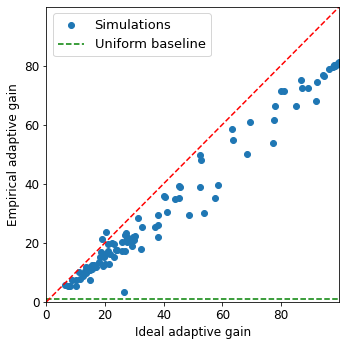

In [13]:
### stopping time for bernoulli setting, Figure 1b
plt.figure(figsize=(5,5))
x = gainArr
y = unifBudgetBatchStop.mean(axis=1)/adaBudgetBatchStop.mean(axis=1)
plt.scatter(x,y,label='Simulations')
plt.axhline(1,color='g', linestyle='--',label='Uniform baseline')
l = min(x.min(),y.min())
h = max(x.max(),y.max())
plt.plot([0,h],[0,h],'--r')
plt.rc('font', size=13)          # controls default text sizes
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

plt.ylabel('Empirical adaptive gain')
plt.xlabel('Ideal adaptive gain')

plt.ylim((0,h))
plt.xlim((0,h))
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('figures/gainPlot_n100_bern.pdf',bbox_inches='tight',pad_inches=0.0)

In [14]:
# showing that uniform and adaptive algorithms attain roughly the same error
print(unifErrorBatchStop.mean(axis=1)/adaErrorBatchStop.mean(axis=1))
print(np.mean(unifErrorBatchStop.mean(axis=1)/adaErrorBatchStop.mean(axis=1)))

[1.1956474  0.93272796 1.07952668 1.0715427  0.95829367 0.94127862
 1.09274818 1.1419297  1.1632727  1.09280581 0.93721285 0.8231459
 1.05759493 1.00826443 1.087225   1.06848338 1.22679182 0.98302844
 1.01200417 0.96419503 1.10552531 1.07510973 1.01548483 1.18569557
 1.07440614 0.99510573 1.06861218 1.10128175 1.03907787 1.06207028
 1.08234141 1.05147377 0.97320932 1.10186868 1.22188682 1.0322692
 0.99453075 1.10753516 0.93137249 0.92437417 1.00940207 0.84493111
 1.08122785 1.05271514 1.00753058 1.13545257 1.01466716 1.13983248
 1.03171911 1.01467227 1.01298407 1.15156121 0.94702469 1.19304897
 0.92439634 1.14635513 0.98464333 1.17438988 1.16180272 1.45950788
 0.94404485 1.02702888 0.95038352 1.13695856 1.10738866 1.20198584
 1.15847136 0.96858465 1.13329886 1.15429506 1.01673481 0.97382559
 1.04450942 1.06348892 0.95087196 1.02281763 1.12071352 1.02509241
 0.9677734  1.07747839 0.97784903 0.99582235 0.98375557 0.94574401
 0.95659653 1.05570154 1.17422403 1.06329253 2.61286649 1.051695